## Ребров. Домашка 4

## Задание 1

In [241]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [242]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

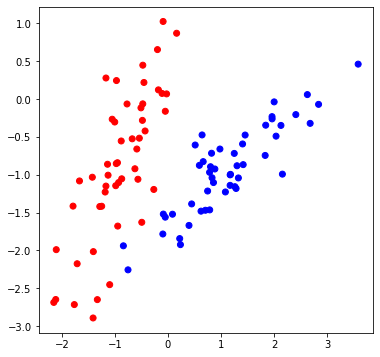

In [243]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [244]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch, level):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.level = level #для 1 задания/ Уровень, чтобы останавливать рекурсию по глубине
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  
    


In [245]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# расчет критерия энтропии
def entropy(labels):
    ''''''
    
    classes = {}
    for label in classification_labels:
        if label not in classes:
            classes[label]=0
        classes[label]+=1
        
    p = []
    for label in classes:
        p.append(classes[label] / len(classification_labels))

    p = np.array(p)
    
    return -(p*np.log2(p)).sum()

In [293]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [294]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Тут изменения: подправил задание мин.кол-ва объектов в листьях
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_objects):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = min_objects

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    leaf_count = []
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            
#             while len(leaf_count) < 4:
                
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
#                 leaf_count.append(true_data)
#                 print(true_data)

    return best_quality, best_t, best_index

# Тут изменения: мин. кол-во объектов в листе и задание глубины дерева
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, level=0, depth=0, min_objects=0):

    quality, t, index = find_best_split(data, labels, min_objects)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
#     Домашка. Прекращаем рекурсию, когда достигли заданной глубины
    if depth != 0 and level == depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    level += 1
    true_branch = build_tree(true_data, true_labels, level, depth, min_objects)
    false_branch = build_tree(false_data, false_labels, level, depth, min_objects)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, level)

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [295]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [296]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, depth = 20, min_objects = 1)

In [297]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

print(f'depth = 20, min_objects = 1')    
print_tree(my_tree)

depth = 20, min_objects = 1
УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.49
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = -0.84
            --> Левая ветка:
                ЛИСТ: прогноз = 1, объектов = 1
            --> Правая ветка:
                ЛИСТ: прогноз = 0, объектов = 1
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 4
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


depth = 20, min_objects = 1, Gini
train_accuracy: 100.0
test_accuracy: 96.66666666666667


Text(0.5, 1.0, 'Test accuracy=96.67')

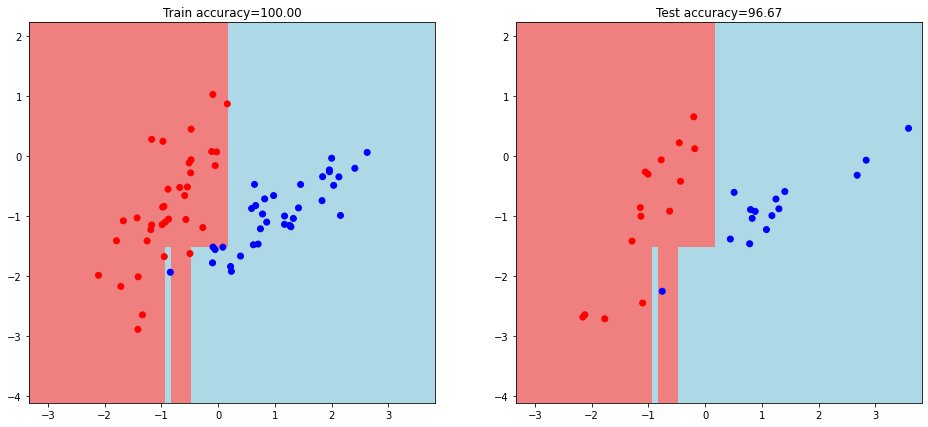

In [298]:
print(f'depth = 20, min_objects = 1, Gini') 
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f'train_accuracy: {train_accuracy}\ntest_accuracy: {test_accuracy}')

# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Задание 2

In [299]:
def quality_entropy(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [300]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Тут изменения: подправил задание мин.кол-ва объектов в листьях
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_objects):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = min_objects

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    leaf_count = []
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            
#             while len(leaf_count) < 4:
                
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_entropy)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
                
#                 leaf_count.append(true_data)
#                 print(true_data)

    return best_quality, best_t, best_index

# Тут изменения: мин. кол-во объектов в листе и задание глубины дерева
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, level=0, depth=0, min_objects=0):

    quality, t, index = find_best_split(data, labels, min_objects)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
#     Домашка. Прекращаем рекурсию, когда достигли заданной глубины
    if depth != 0 and level == depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    level += 1
    true_branch = build_tree(true_data, true_labels, level, depth, min_objects)
    false_branch = build_tree(false_data, false_labels, level, depth, min_objects)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, level)

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [319]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, depth = 20, min_objects = 1)

In [320]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

print(f'depth = 20, min_objects = 1')    
print_tree(my_tree)

depth = 20, min_objects = 1
УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -2.11
         --> Левая ветка:
             ЛИСТ: прогноз = 0, объектов = 1
         --> Правая ветка:
            УЗЕЛ: индекс = 0, порог = -1.71
            --> Левая ветка:
                ЛИСТ: прогноз = 0, объектов = 1
            --> Правая ветка:
               УЗЕЛ: индекс = 0, порог = -1.41
               --> Левая ветка:
                   ЛИСТ: прогноз = 0, объектов = 1
               --> Правая ветка:
                  УЗЕЛ: индекс = 0, порог = -1.41
                  --> Левая ветка:
                      ЛИСТ: прогноз = 0, объектов = 1
                  --> Правая ветка:
                     УЗЕЛ: индекс = 0, порог = -1.33
                     --> Левая ветка:
                         ЛИСТ: прогноз = 0, объектов = 1
                     --> Правая 

depth = 20, min_objects = 1, Entropy
train_accuracy: 100.0
test_accuracy: 96.66666666666667


Text(0.5, 1.0, 'Test accuracy=96.67')

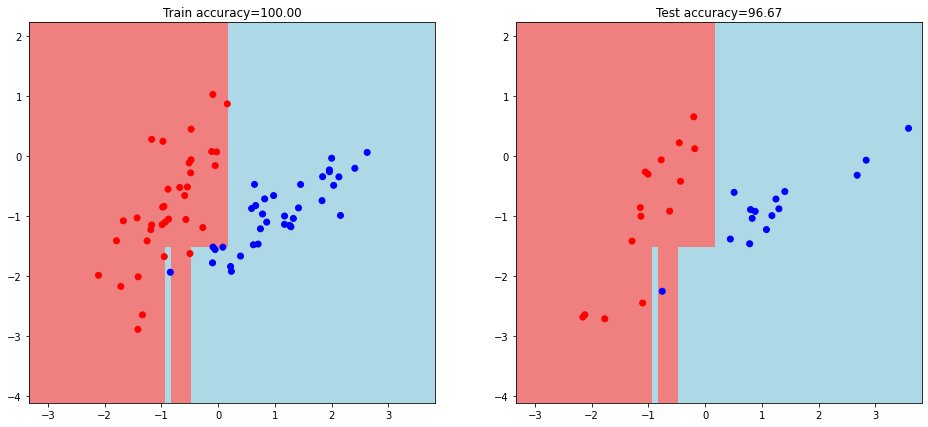

In [321]:
print(f'depth = 20, min_objects = 1, Entropy') 
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f'train_accuracy: {train_accuracy}\ntest_accuracy: {test_accuracy}')

# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Вывод: на этом датасете критерии Джини и энтропии показали одинаковый результат в плане точности, но дерьевья получились разные. Причем, чем меньше ограничение глубины дерева, тем меньше разница между глубиной деревьев при использовании разных критериев. Потом мне стало любопытно, куда это приведет, и я увеличил глубину дерева и уменьшил количество объектов в листе. С критерием энтропии дерево получилось просот огромным, а критерий джини не так сильно увеличил дерево, хотя результат классификации остался одинаковым. Но точность на тестовой выборке упала по сравнению с более строгими ограничениями. Покрутив параметры глубины и количества объектов в листе, я решил, что большее влияние на точность оказывает ограничение кол-ва объектов в листе. Возможно, это справедливо только с конкретным датасетом. 